In [23]:
import numpy as np
from dualtime.src.mclachlan import VarQITE
from gibbs.utils import create_hamiltonian_lattice,printarray,expected_state,state_from_ansatz, simple_purify_hamiltonian,expected_state, create_heisenberg
from gibbs.preparation.varqite import brute_force_optimization
from gibbs.preparation.free_energy import brute_cmaes
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from qiskit.circuit import ClassicalRegister
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp,Statevector, state_fidelity, DensityMatrix
from gibbs.learning.hamiltonian_learning import HamiltonianLearning
from scipy.linalg import expm, logm
import matplotlib.pyplot as plt
from gibbs.dataclass import VarQITEResult

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
new_result = VarQITEResult.load("test")
new_result.H_original

array([ 0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j, -0.54433105+0.j, -0.54433105+0.j,
       -0.54433105+0.j,  0.13608276+0.j,  0.13608276+0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.13608276+0.j,  0.13608276+0.j,  0.        +0.j,
        0.        +0.j,  0.        +0.j,  0.        +0.j,  0.        +0.j,
        0.        +0.j,  0.13608276+0.j,  0.13608276+0.j])

In [19]:
hamiltonian = create_hamiltonian_lattice(4,1/4,-1)
op = SparsePauliOp.from_list([("ZIII",1)])
(hamiltonian @ op - op @ hamiltonian).simplify()

SparsePauliOp(['YIII'],
              coeffs=[0.+2.j])

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'XXII', 'IXXI', 'IIXX', 'YYII', 'IYYI', 'IIYY', 'ZZII', 'IZZI', 'IIZZ'],
              coeffs=[-0.46816459+0.j, -0.46816459+0.j, -0.46816459+0.j, -0.46816459+0.j,
  0.11704115+0.j,  0.11704115+0.j,  0.11704115+0.j,  0.11704115+0.j,
  0.11704115+0.j,  0.11704115+0.j,  0.11704115+0.j,  0.11704115+0.j,
  0.11704115+0.j])


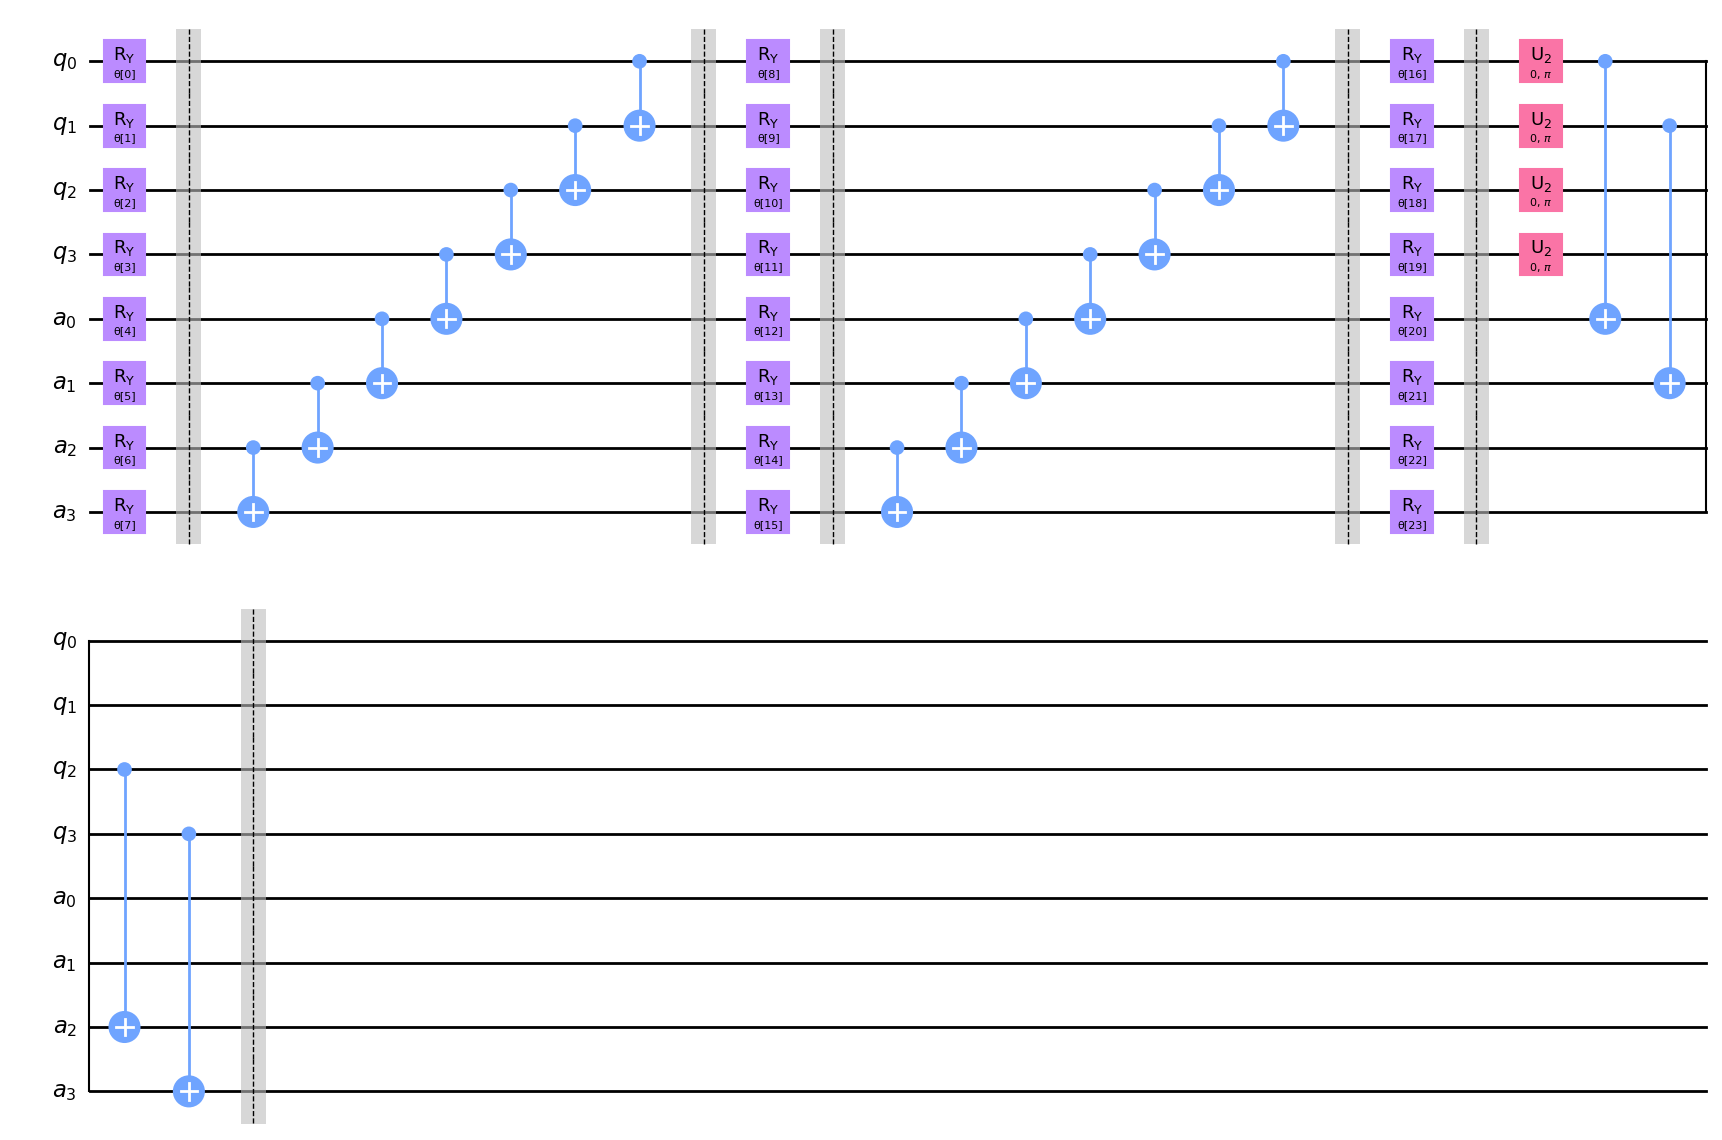

In [2]:
beta = 5
local_basis = KLocalPauliBasis(k=2,num_qubits=4,periodic=False)
hamiltonian = create_heisenberg(4,1/4,-1)
hamiltonian_vec = local_basis.pauli_to_vector(hamiltonian); hamiltonian_vec /= np.linalg.norm(hamiltonian_vec)
hamiltonian = local_basis.vector_to_pauli_op(hamiltonian_vec)
print(hamiltonian)
N = hamiltonian.num_qubits
ansatz,x0 = pauli_rotations_ansatz(hamiltonian,depth = 2,entanglement="reverse_linear",su2_gates=["ry"])
# display(ansatz.decompose().draw(output="mpl"))

In [3]:
varqite = VarQITE(ansatz,x0,backend=None)
steps = 8
result_varqite = varqite.evolve(PauliSumOp(hamiltonian^("I"*N)),beta/2,timestep = beta/(2*steps))
final_state = state_from_ansatz(ansatz,result_varqite.parameters[-1])
theoretical_state = expected_state(hamiltonian,beta = 2*result_varqite.times[-1])
print("We have gotten a gibbs state with fidelity:",state_fidelity(final_state,theoretical_state))

0
0.3125
0.625
0.9375
1.25
1.5625
1.875
2.1875
We have gotten a gibbs state with fidelity: 0.900019522209379


In [20]:
hl = HamiltonianLearning(ansatz,2,3,parameters=result_varqite.parameters,periodic=False)
Hf_vecs, Hf_norms = hl.classical_learn_hamiltonian(k=0)
print(Hf_vecs)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


[0.0, 0.5897342843490236, 1.182217358685001, 1.795530270044666, 2.491879267295354, 4.013421455361562, 3.7343212028188884, 4.019745461519144, 3.8888838101512855]


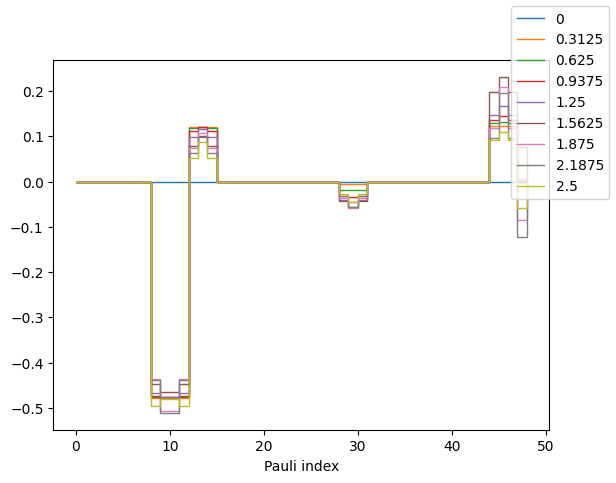

In [ ]:
print(norms)
fig,ax = plt.subplots()
for t,H_vec in zip(result_varqite.times,H_vecs):
    ax.stairs(H_vec,label = t)
ax.set_xlabel("Pauli index")
fig.legend()